Welcome to the EPISOL Colab Playground!



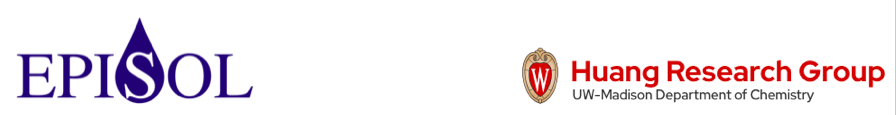

The 3D reference interaction site model (3DRISM) provides an efficient grid-based solvation model to compute the structural and thermodynamic properties of biomolecules in aqueous solutions, in this notebook we will walk through a high-throughput calculation on the solvation free energy of a test set of small molecules. We will compare our 3DRISM results to those of experimentally and computationally (FEP) determined free energies.   

* **goals**:
  * Generate the coordinate and topology files for our test set using RDKit and openFF
  * Perform high-throughput 3DRISM calculations to determine solvation free energy of 100 molecules in the test set
  * Be able to perform similar calculations on your own molecules
    * use the colab-notebook to download and run calculations on your own molecules

In [1]:
#@title ##Download and Install Episol
#@markdown ($\approx 2$min) Stable as of 07/01/25 eprism v1.2.6
%%capture
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
#%cd ../home/
%cd $HOME/
%mkdir episol
%cd episol
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/fftw/fftw-3.3.8.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded fftw files"
!echo "+++++++++++++++++++"
!tar -xzf fftw-3.3.8.tar.gz
%cd fftw-3.3.8/
#!./configure --prefix=/home/fftw-3.3.8
!./configure --prefix=$HOME/episol/fftw-3.3.8
!make
!make install
%cd ../
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/kernel/release.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded Episol files"
!echo "+++++++++++++++++++"
!tar -xzf release.tar.gz
%cd release/
#!./configure --with-fftw=/home/fftw-3.3.8
!./configure --with-fftw=$HOME/episol/fftw-3.3.8
!make
!make install
#%cd /content
########################### WRAPEPR
import subprocess
import os
import threading
import pandas as pd
import matplotlib.pyplot as plt
!pip install episol


In [2]:
%%capture
#@title Install some python packages for topology generation ($\approx$2min)
#@markdown This will prompt a restart in our colab session, this is necessary, just keep moving

#@markdown (if you are using the notebook offline this wont be necessary, as presumably you'll have your own forcefield to generate topologies)
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install --yes -c conda-forge numpy=1.26.4 openmm pdbfixer parmed mdanalysis py3dmol rdkit openff-toolkit
#openmm pdbfixer parmed mdanalysis py3dmol rdkit


In [141]:
#@title import our download packages
%%capture
def UC():
  """
  Function to get universal correction (UC) based on the closure
  used for RISM calculation.
  ----------------------------
  function returns a dictionaryy containing both the FEP and
  experimental correction constants 'A' and 'B' in the equation:
  \delta G^{solv} = \mu^{ex}+'A'*V_m+'B', where V_m is partial molar volume
  from the free energy universal correction proposed by:
  David S Palmer, Andrey I Frolov, Ekaterina L Ratkova and Maxim V Fedorov
  http://dx.doi.org/10.1088/0953-8984/22/49/492101
  """
  match test.closure:
    case "KH":
       return {"FEP":[-647.348453608648,4.8547480416612],
               "EXP":[-619.952559990907,-1.47859772642391]}
    case "KGK":
       return {"FEP":[-462.53443482818,8.04130525293397],
               "EXP":[-435.780764679989,1.67322083808028]}
    case "PSE2":
       return {"FEP":[-687.908213741747,3.5610101387673],
               "EXP":[-657.653298424423,-2.65897745235407]}
    case "PSE3":
       return {"FEP":[-702.709116407626,3.75516272446305],
               "EXP":[-671.598836677146,-2.44628209193456]}
    case "PSE4":
       return {"FEP":[-710.201646298877,4.17184421269326],
               "EXP":[-684.990022127642,-1.17317388291133]}
    case "PSE5":
       return {"FEP":[-714.134748976177,4.40755095859481],
               "EXP":[-692.678698950017,-0.430203751105637]} # fitted at alpha=3
    case "PLHNC":
       return {"FEP":[-710.548315106323,4.20537805720096],
               "EXP":[-678.964891475467,-2.0042752246319]}  # fitted at alpha=3
    case "HNC":
      return {"FEP":[-710.548315106323,4.20537805720096],
              "EXP":[-678.964891475467,-2.0042752246319]}  # HNC is simply copied from PLHNC
def free_energy(fit_value:str='EXP'):
  """
  Return the free energy of the most recent calculation according to the
  3DRISM object
  ====================
  sit_value: string, energy value to return
  EXP : experiment
  FEP : free energy of pertubation
  """
  assert fit_value == ("EXP" or "FEP"), "you must choose EXP or FEP"
  return UC()[fit_value]
free_energy("EXP")
import matplotlib.pyplot as plt
import openmm as mm
from   openmm import app
from   openmm.unit import *
import py3Dmol as pymol
import MDAnalysis as md
import parmed as chem
from openff.toolkit.topology import Molecule, Topology
import numpy as np
from MDAnalysis.transformations import center_in_box
from episol import epipy
from rdkit import Chem
from rdkit.Chem import AllChem
from openff.toolkit.topology import Molecule
from openff.toolkit.utils import get_data_file_path
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.interchange import Interchange
%cd /content/

#**Walk Through Calculation:**

* for this tutorial we will look at the solvation free energy of small molecules using FreeSolv Database
* lets download our files

In [2]:
!wget https://github.com/MobleyLab/FreeSolv/raw/refs/heads/master/database.txt

--2025-07-25 14:55:10--  https://github.com/MobleyLab/FreeSolv/raw/refs/heads/master/database.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MobleyLab/FreeSolv/refs/heads/master/database.txt [following]
--2025-07-25 14:55:11--  https://raw.githubusercontent.com/MobleyLab/FreeSolv/refs/heads/master/database.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144897 (142K) [text/plain]
Saving to: ‘database.txt’

database.txt        100%[===================>] 141.50K  --.-KB/s    in 0.004s  

2025-07-25 14:55:11 (38.1 MB/s) - ‘database.txt’ saved [144897/144897]



* now we convert the smiles string to a .gro file and generate topologies for each molecule

In [83]:
line_count = int()
experimental_values = []
calculated_values = []
smiles_list = []
names_list = []

with open('database.txt','r') as r:
  for line in r:
    line_count +=1
    if line_count > 3:
      tmp = line.split(';')
      try:
        names_list.append('_'.join(tmp[2].split()))
        smiles_list.append(tmp[1].strip())
        experimental_values.append(float(tmp[3].strip()))
        calculated_values.append(float(tmp[5].strip()))
      except Exception as exc:
        RuntimeWarning(exc)
smiles_list = np.array(smiles_list)
names_list = np.array(names_list)
experimental_values = np.array(experimental_values)
calculated_values = np.array(calculated_values)


* lets look at our molecules

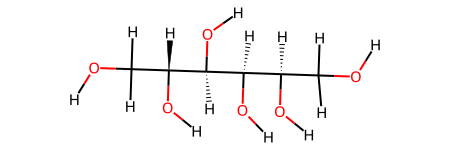

In [85]:
rng = np.random.default_rng()
ind_to_extract = rng.integers(len(smiles_list),size=1)[0]
test = smiles_list[ind_to_extract]

mol = Chem.MolFromSmiles(test)
mol = Chem.rdmolops.AddHs(mol,addCoords=True)
mol

* we can see our molecule has totally non-physical geometry
* lets preform a simple geometry optimizationn step and view the output

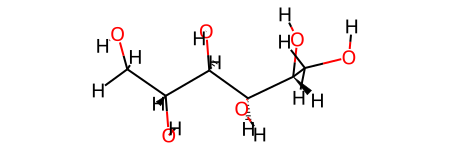

In [86]:
AllChem.EmbedMolecule(mol)
AllChem.UFFOptimizeMolecule(mol)
mol

* much better
* now lets investigate solvation free energy of our molecules
* we can do the entire test set if youd like, but for now lets just select 100 molecules at random

In [121]:
number_of_molecules_to_use = 100

rng = np.random.default_rng()
ind_to_extract = rng.integers(len(smiles_list),size=number_of_molecules_to_use)

#smiles_and_names = dict(zip(names_list[ind_to_extract],smiles_list[ind_to_extract]))
smiles_and_names = dict(zip(names_list[:number_of_molecules_to_use],smiles_list[:number_of_molecules_to_use]))


Run $\approx$ 2min for the first 100

In [134]:
%%capture
import os
#mols = [Chem.MolFromSmiles(x) for x in smiles_list[:5]]
out_energies = []
for name in smiles_and_names.keys():
  mol = Chem.MolFromSmiles(smiles_and_names[name])
  mol = Chem.rdmolops.AddHs(mol,addCoords=True)

  # geometry optimization step
  AllChem.EmbedMolecule(mol)
  AllChem.UFFOptimizeMolecule(mol)
  ##
  # use openFF..toolkit to accept rdkit object
  from_rdmol = Molecule.from_rdkit(mol,allow_undefined_stereo=True)
  topology = from_rdmol.to_topology()
  # we will use openFF to assign SMIRNOFF parameters
  sage = ForceField("openff-2.0.0.offxml")
  interchange = Interchange.from_smirnoff(force_field=sage, topology=topology)
  # just pick the first conformer
  interchange.positions = from_rdmol.conformers[0]
  #openmm_system = interchange.to_gromacs('out')
  openmm_system = interchange.to_openmm()
  #os.remove("out.top")
  interchange.to_top("out.top")
  tmp_u = md.Universe(mol)
  coords = tmp_u.atoms.positions
  # Buffer will be greater than 1nm (our default cutoff)
  # here we set to 7A on each side, so at least 1.4 nm apart from the other side of
  # the molecule
  buffer = 5  # convert to A
  #

  box_x = np.ceil(np.abs(np.max((coords[:,0]))-np.min((coords[:,0])))+buffer)
  box_y = np.ceil(np.abs(np.max((coords[:,1]))-np.min((coords[:,1])))+buffer)
  box_z = np.ceil(np.abs(np.max((coords[:,2]))-np.min((coords[:,2])))+buffer)
  tmp_u.dimensions = [box_x,box_y,box_z,90,90,90]
  trans = center_in_box(tmp_u.atoms,center='geometry')

  tmp_u.trajectory.add_transformations(trans)
  tmp_u.atoms.write(f'fixed_mol.gro') # have to write out structure file
  ## run 3DRISM
  test = epipy(f'fixed_mol.gro','out.top',gen_idc=True)
  test.ndiis = 15
  test.delvv = 0.5
  test.r_c = 0.9 # cutoff at 0.9 nm instead of 1 nm (default)
  test.err_tol = 1e-12
  test.rism(resolution=0.5)
  test.kernel(nt=2)
  # do stuff
  A,B = UC()["FEP"]
  with open('fixed_mol_out.log','r') as rr:
    for line in rr:
      t = line.split()
      if t[0] == 'total':
        out_energies.append(float(t[10])+float(t[8])*A+B)
  rr.close()
  # get rid of our calculation files
  # we dont really care about saving them
  # this way we dont have files piling up
  try:
    os.remove("out.top")
    os.remove('fixed_mol_out.ts4s')
    os.remove('fixed_mol_out.log')
  except FileNotFoundError:
    continue

In [116]:
test.closure

'PSE3'

In [135]:
out_en = np.copy(np.array(out_energies))*(0.239006/1.000001104) # kcal to KJ

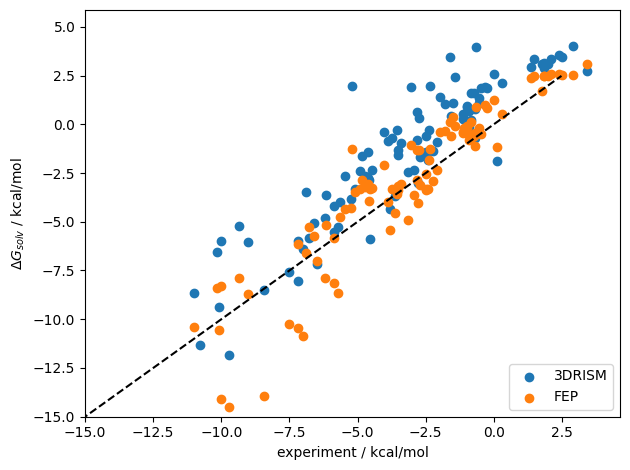

In [136]:
fig,ax = plt.subplots()

out_energies = np.copy(np.array(out_en))
dslice = len(out_energies)
ax.scatter(experimental_values[:number_of_molecules_to_use],out_energies,label='3DRISM')
ax.scatter(experimental_values[:number_of_molecules_to_use],calculated_values[:number_of_molecules_to_use],label='FEP')
#ax1.scatter(calculated_values[:dslice],out_energies)
#ax1.set_xlabel("experimental values")
ax.set_ylabel("$\\Delta G_{solv}$ / kcal/mol")
ax.set_xlabel("experiment / kcal/mol")
vv = np.arange(min(experimental_values[:dslice]),max(experimental_values[:dslice]))
ax.plot(vv,vv,'k--')
ax.set_ylim(-15,None)
ax.set_xlim(-15,None)
ax.legend(loc="lower right")
fig.tight_layout()

# Tutorial finished!

In [191]:
np.arange(min(calculated_values[:dslice]),max(calculated_values[:dslice]))

array([-17.24, -16.24, -15.24, -14.24, -13.24, -12.24, -11.24, -10.24,
        -9.24,  -8.24,  -7.24,  -6.24,  -5.24,  -4.24,  -3.24,  -2.24,
        -1.24,  -0.24,   0.76,   1.76,   2.76])

In [ ]:
smiles_list = []
names_list = []

ps = chem.load_file('nitrous.sdf')
molecule: Molecule = Molecule.from_file("nitrous.sdf")
topology: Topology = molecule.to_topology()
sage = ForceField("openff-2.0.0.offxml")
interchange = Interchange.from_smirnoff(force_field=sage, topology=topology)
interchange.positions = molecule.conformers[0]
openmm_system = interchange.to_openmm()
interchange.to_top("out.top")

## Here we set the box dimensions and center our molecule for viewing purposes
nn = md.Universe(chem.load_file('nitrous.sdf',structure=True))
nn.dimensions = np.array([30,30,30,90,90,90])
nn.dimensions
print(nn.atoms.positions)
tt = center_in_box(nn.atoms,center='geometry')
nn.trajectory.add_transformations(tt)
print(nn.atoms.positions)
nn.atoms.write('nitrous_.gro')